## Portfolio simulation

In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class import PortfolioSimulation
import matplotlib.pyplot as plt


In [2]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})

In [ ]:
stock_prices.groupy("date")["price"].sum()

In [3]:
# LLM recommendations
llm_recommendations1 = pd.read_csv("../data/ciks1_ratings.csv", dtype={"cik": str})
llm_recommendations1.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)
llm_recommendations2 = pd.read_csv("../data/ciks2_ratings.csv", dtype={"CIK": str})
llm_recommendations2.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations3 = pd.read_csv("../data/ciks3_ratings.csv", dtype={"CIK": str})
llm_recommendations3.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations4 = pd.read_csv("../data/ciks4_ratings.csv", dtype={"CIK": str})
llm_recommendations4.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations5 = pd.read_csv("../data/ciks5_ratings.csv", dtype={"CIK": str})
llm_recommendations5.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations6 = pd.read_csv("../data/ciks6_ratings.csv", dtype={"CIK": str})
llm_recommendations6.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  

# Concat all llm recommendations into one DataFrame
llm_recommendations = pd.concat([
    llm_recommendations1, llm_recommendations2, llm_recommendations3,
    llm_recommendations4, llm_recommendations5, llm_recommendations6
], ignore_index=True)

In [4]:
import re

def extract_signal(text):
    # Define possible signals
    signals = ['strong buy', 'buy', 'hold', 'sell', 'strong sell']
    
    # Check if any of the signals appear in the text
    for signal in signals:
        if signal in text.lower():
            return signal
    
    # Return None if no signal is found
    return text

- Subsetting CIK date combinations that are present in LLM recommendations as well as sell-side analyst ratings

In [5]:
# Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M")
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M")
# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)

In [6]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
# Merge to find common CIK and date combinations
all_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

In [7]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_final["date"] = llm_recommendations_final["date"].astype(str)
analyst_ratings_final["date"] = analyst_ratings_final["date"].astype(str)

In [8]:
len(all_ciks_and_dates), len(llm_recommendations_final), len(analyst_ratings_final)

(40076, 40076, 40076)

---
### Selected stock test simulation 

In [9]:
ciks = llm_recommendations_final["cik"].unique()[:2]
ciks

array(['0001996862', '0001049502'], dtype=object)

In [ ]:
# Subset 1 CIK for testing
#cik = "0001996862"
cik_prices = stock_prices[stock_prices["cik"].isin([ciks][0])]
cik_llm_recommendations = llm_recommendations_final[llm_recommendations_final["cik"].isin([ciks][0])]

In [11]:
cik_llm_recommendations

,cik,date,rating,action
0,0001996862,2001-09,sell,sell
1,0001996862,2001-12,hold,hold
2,0001996862,2002-03,sell,sell
3,0001996862,2002-06,sell,sell
4,0001996862,2002-09,hold,hold
...,...,...,...,...
182,0001049502,2022-12,hold,hold
183,0001049502,2023-03,sell,sell
184,0001049502,2023-06,sell,sell
185,0001049502,2023-09,hold,hold


In [36]:
start_capital = 1000000
cik_sim = PortfolioSimulation(initial_capital = start_capital)
cik_sim.load_stock_prices(cik_prices)
cik_sim.load_recommendations(cik_llm_recommendations)

# Run simulation
cik_sim.simulate_trading()

Simulating Trades: 100%|██████████| 187/187 [00:00<00:00, 1187.45it/s]


In [13]:
cik_sim.portfolio_statistics()

Calculating Monthly Returns: 100%|██████████| 288/288 [00:00<00:00, 395.45it/s]


{'Mean return (monthly)': np.float64(1.1e-05),
 'Geometric mean return (monthly)': np.float64(1.1e-05),
 'Standard deviation (monthly)': np.float64(0.000647),
 'Annualized mean return': np.float64(0.000133),
 'Annualized standard deviation': np.float64(0.002243),
 'Number of buys': 24,
 'Number of sells': 15,
 'Total number of transactions': 39,
 'Number of skipped buys': 0,
 'Number of skipped sells': 80,
 'Total number of skipped transactions': 80}

In [14]:
cik_returns = cik_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 288/288 [00:00<00:00, 389.42it/s]


In [ ]:
cik_sim_positions = cik_sim.get_positions_over_time()
cik_sim_positions = cik_sim_positions.sort_values(by="date")
cik_sim_positions

Getting Positions Over Time: 100%|██████████| 289/289 [00:00<00:00, 722.61it/s] 


,date,cik,quantity,total_value
0,1999-12,cash,1000000,1000000.00
1,2000-01,cash,1000000,1000000.00
2,2000-02,cash,1000000,1000000.00
3,2000-03,cash,1000000,1000000.00
4,2000-04,cash,1000000,1000000.00
...,...,...,...,...
527,2023-11,0001049502,9,742.95
526,2023-11,cash,999388,999388.19
530,2023-12,0001996862,1,100.95
529,2023-12,0001049502,8,822.96


---

### LLM recommendations simulation

In [45]:
# Initialize portfolio simulation
llm_sim = PortfolioSimulation(initial_capital=start_capital)

# Load data
llm_sim.load_stock_prices(stock_prices)
llm_sim.load_recommendations(llm_recommendations_final)

# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 40076/40076 [10:11<00:00, 65.50it/s]


In [46]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [21:32<00:00,  4.21s/it]


In [47]:
llm_sim.portfolio_statistics(monthly_returns =  llm_returns)

{'Mean return (monthly)': np.float64(0.003586),
 'Geometric mean return (monthly)': np.float64(0.003338),
 'Standard deviation (monthly)': np.float64(0.022335),
 'Annualized mean return': np.float64(0.043893),
 'Annualized standard deviation': np.float64(0.077371),
 'Number of buys': 4105,
 'Number of sells': 2588,
 'Total number of transactions': 6693,
 'Number of skipped buys': 0,
 'Number of skipped sells': 14347,
 'Total number of skipped transactions': 14347}

Text(0.5, 0, 'Date')

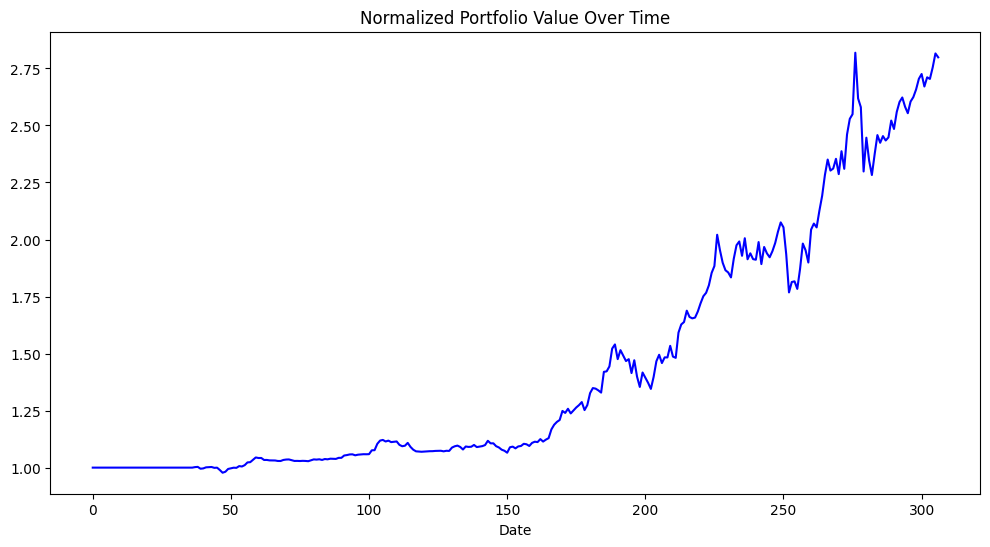

In [48]:
# plot start value over time
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 6))
plt.plot(llm_returns.index, llm_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')

In [49]:
llm_positions = llm_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 308/308 [11:24<00:00,  2.22s/it]


In [50]:
llm_positions

,date,cik,quantity,total_value
0,1999-03,cash,1000000,1000000.00
1,1999-04,cash,1000000,1000000.00
2,1999-05,cash,1000000,1000000.00
3,1999-06,cash,1000000,1000000.00
4,1999-07,cash,1000000,1000000.00
...,...,...,...,...
36255,2024-10,0000109198,11,1243.33
36256,2024-10,0000355811,37,1121.47
36257,2024-10,0001278021,30,8682.60
36258,2024-10,0000940942,3,130.17


---
### Analyst recommendations simulation

In [51]:
analyst_sim = PortfolioSimulation(initial_capital=start_capital)
analyst_sim.load_stock_prices(stock_prices)
analyst_sim.load_recommendations(analyst_ratings_final)
analyst_sim.simulate_trading()

Simulating Trades: 100%|██████████| 40076/40076 [11:50<00:00, 56.43it/s]


In [52]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [41:21<00:00,  8.08s/it]


In [53]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.003513),
 'Geometric mean return (monthly)': np.float64(0.003205),
 'Standard deviation (monthly)': np.float64(0.024854),
 'Annualized mean return': np.float64(0.042979),
 'Annualized standard deviation': np.float64(0.086097),
 'Number of buys': 18845,
 'Number of sells': 147,
 'Total number of transactions': 18992,
 'Number of skipped buys': 8184,
 'Number of skipped sells': 227,
 'Total number of skipped transactions': 8411}

Text(0.5, 0, 'Date')

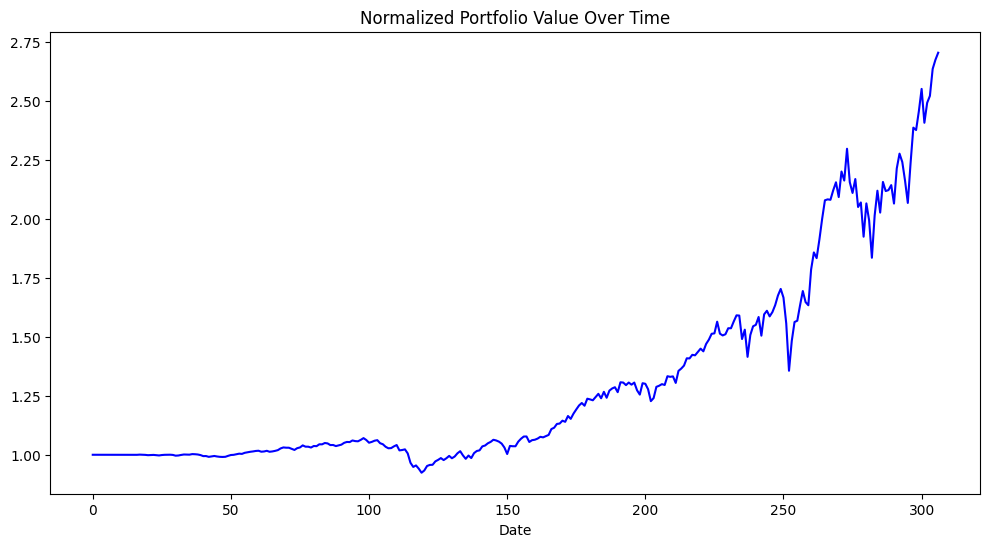

In [54]:
# plot start value over time
plt.figure(figsize=(12, 6))
plt.plot(analyst_returns.index, analyst_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')

In [55]:
analyst_positions = analyst_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 308/308 [20:05<00:00,  3.91s/it]


In [56]:
df = analyst_positions.reset_index(drop=False)
df

,index,date,cik,quantity,total_value
0,0,1999-03,cash,1000000,1000000.00
1,1,1999-04,cash,1000000,1000000.00
2,2,1999-05,cash,1000000,1000000.00
3,3,1999-06,cash,1000000,1000000.00
4,4,1999-07,cash,1000000,1000000.00
...,...,...,...,...,...
85726,85726,2024-10,0001071739,62,3860.12
85727,85727,2024-10,0001075531,51,238488.75
85728,85728,2024-10,0001076930,36,6128.64
85729,85729,2024-10,0001083446,1,53.78


---

#### Analysis of  PF composition over time 

In [57]:
def plot_pf_shares_over_time(positions_df):
    df = positions_df.reset_index(drop=False)
    df["date"] = df["date"].astype(str)  # Ensure date is string for consistency
    dates = df["date"].unique()

    pf_data = []

    # Calculate cash and stock share for each date
    for date in dates:
        positions = df[df["date"] == date]
        cash_row = positions[positions["cik"] == "cash"]

        if cash_row.empty:
            continue  # Skip if no cash row

        cash_value = cash_row["total_value"].values[0]
        stocks_value = positions[positions["cik"] != "cash"]["total_value"].sum()

        total = cash_value + stocks_value
        if total == 0:
            continue  # Avoid division by zero

        pf_data.append({
            "date": date,
            "cash_share": cash_value / total,
            "stocks_share": stocks_value / total
        })

    pf_shares = pd.DataFrame(pf_data)
    pf_shares.set_index("date", inplace=True)

    plt.figure(figsize=(9, 6))
    plt.plot(dates, pf_shares["cash_share"], label="Cash Share", color="blue")
    plt.plot(dates, pf_shares["stocks_share"], label="Stocks Share", color="orange")

    plt.xticks(dates[::12], rotation=45)


    plt.title("Portfolio Composition Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Share")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


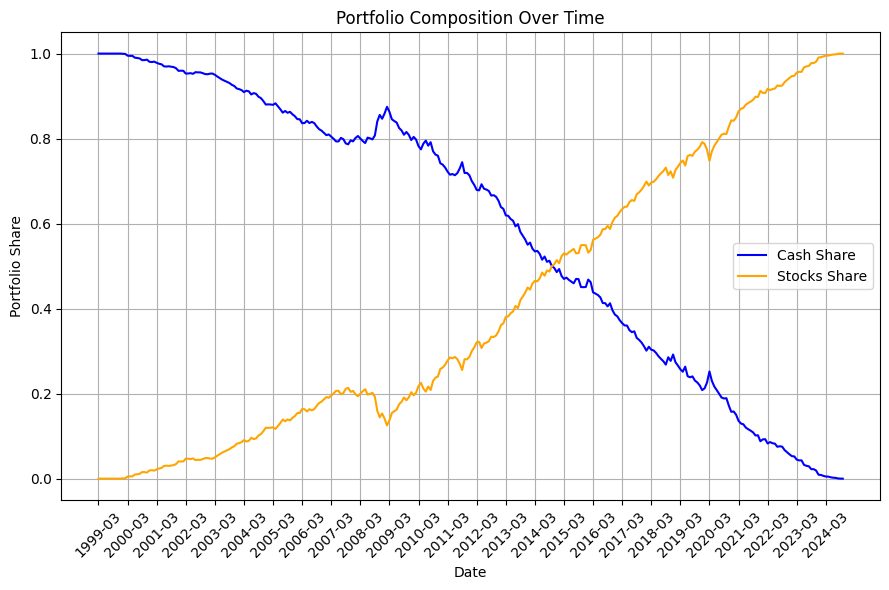

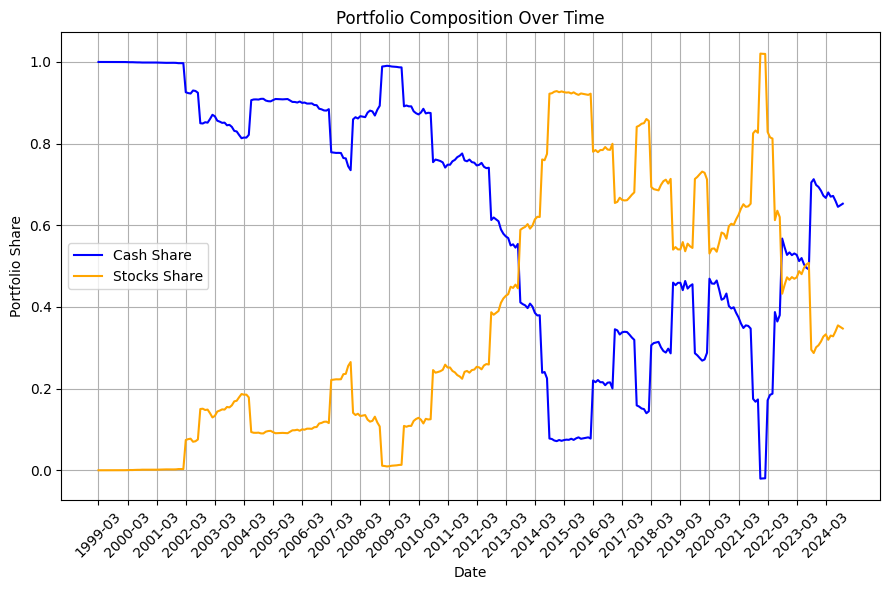

(None, None)

In [58]:
plot_pf_shares_over_time(analyst_positions), plot_pf_shares_over_time(llm_positions)

In [59]:
def plot_pf_shares_over_time2(positions_df):
    df = positions_df.reset_index(drop=False)
    df["date"] = df["date"].astype(str) 
    dates = df["date"].unique()

    pf_data = []

    # Calculate cash and stock share for each date
    for date in dates:
        positions = df[df["date"] == date]
        cash_row = positions[positions["cik"] == "cash"]

        if cash_row.empty:
            continue  # Skip if no cash row

        cash_value = cash_row["total_value"].values[0]
        stocks_value = positions[positions["cik"] != "cash"]["total_value"].sum()

        total = cash_value + stocks_value
        if total == 0:
            continue  # Avoid division by zero

        pf_data.append({
            "date": date,
            "cash_share": cash_value / total,
            "stocks_share": stocks_value / total
        })

    pf_shares = pd.DataFrame(pf_data)
    pf_shares.sort_values("date", inplace=True)
    pf_shares.set_index("date", inplace=True)

    # Stacked area plot
    plt.figure(figsize=(9, 6))
    plt.stackplot(
        dates,
        pf_shares["cash_share"],
        pf_shares["stocks_share"],
        labels=["Cash", "Stocks"],
        colors=["skyblue", "orange"]
    )

    plt.xticks(dates[::12], rotation=45)
    plt.title("Portfolio Composition Over Time")
    plt.ylabel("Portfolio Share")
    plt.ylim(0, 1)
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


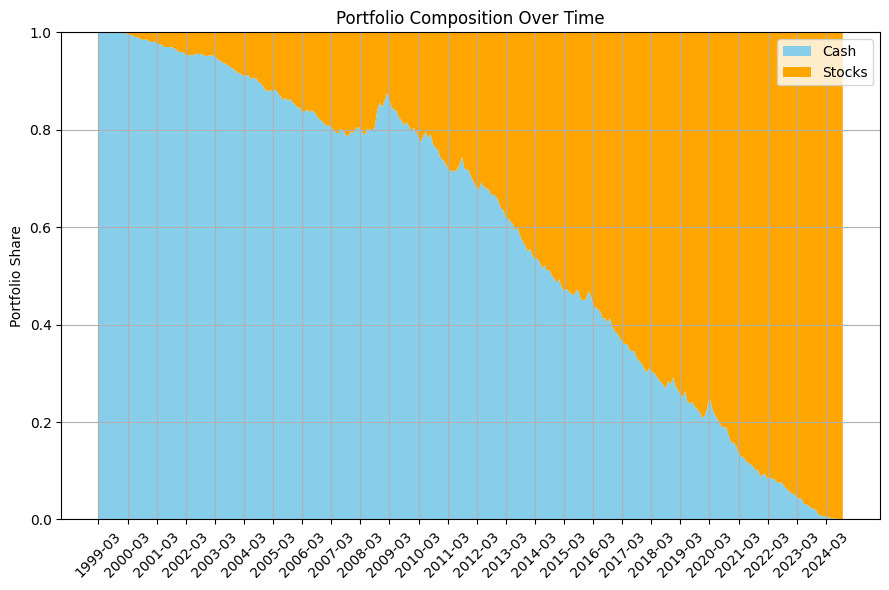

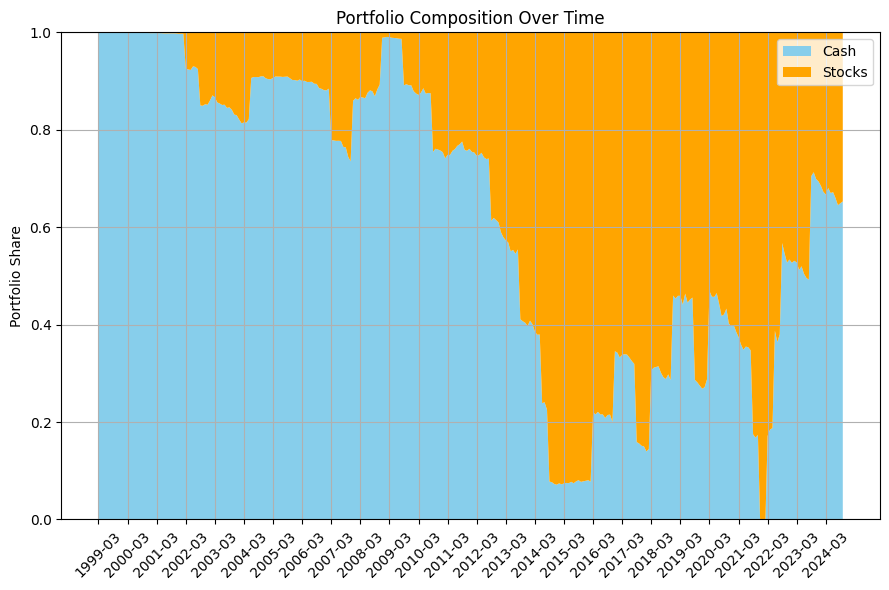

(None, None)

In [60]:
plot_pf_shares_over_time2(analyst_positions), plot_pf_shares_over_time2(llm_positions)